# AI-LAB LESSON 6: Deep Reinforcement Learning

In this lesson we will use the CartPole environment and we will see how to create and work with a neural network using Kears on top of Tensorflow.

## CartPole
The environment used is **CartPole** (taken from the book of Sutton and Barto as visible in the figure)

![Cartpole](images/cartpole.jpg)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [37]:
import os, sys, tensorflow.keras, random, numpy
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

The **state** of environment is represented as a tuple of 4 values: 
- *Cart Position* range from -4.9 to 4.8
- *Cart Velocity* range from -inf to +inf
- *Pole Angle* range from -24 deg to 24 deg
- *Pole Velocity* range from -inf to +inf

The **actions** allowed in the environment are 2:
- *action 0*: push cart to left
- *action 1*: push cart to right

The **reward** is 1 for every step taken, including the termination step.

In [38]:
env = gym.make("CartPole-v1")
state = env.reset()
print("STARTING STATE: {}".format(state))
print("\tCart Position: {}\n\tCart Velocity {}\n\tPole Angle {} \n\tPole Velocity {}".format(state[0], state[1], state[2], state[3]))

print("\nPOSSIBLE ACTIONS: ", env.action_space.n)

new_state, rew, done, _ = env.step(0)
print("push left --> s' {} r {} done {} \n".format(new_state, rew, done))

STARTING STATE: [ 0.01432769 -0.04023467  0.0059909   0.01141211]
	Cart Position: 0.01432768883582329
	Cart Velocity -0.04023466981355023
	Pole Angle 0.00599089712326506 
	Pole Velocity 0.011412106561136205

POSSIBLE ACTIONS:  2
push left --> s' [ 0.013523   -0.23544202  0.00621914  0.3059792 ] r 1.0 done False 



Finally, we still have the standard functionalities of a Gym environment:
- step(action): the agent performs action from the current state. Returns a tuple (new_state, reward, done, info) where:
    - new_state: is the new state reached as a consequence of the agent's last action
    - reward: the reward obtained by the agent in this step
    - done: True if the episode is terminal, False otherwise
    - info: not used, you can safely discard it

- reset(): the environment is reset and the agent goes back to the starting position. Returns the initial state id

## Neural network with Kears
**Keras** is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, R, Theano, or PlaidML. Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible.

![Network](images/neural_networks.png)

With **Keras** you can easly create a neural network with the **Sequential** module. Before training a neural netowrk you must compile it, selecting the loss function and the optimizer. In our lab session we will use the *mean_squared_error* for the loss function and the *adam* optimizer, that is a standard configuration for the DQN approach.

In [39]:
#Come creare una feedforward neural network in keras

#numero di livelli di input, layer, output
input_layer = 3
layer_size = 5
output_layer = 2

#creo il modello di tipo sequenziale
model = Sequential()
#aggiungiamo i vari elementi
model.add(Dense(layer_size, input_dim=input_layer, activation="relu")) #input layer + hidden layer #1
model.add(Dense(layer_size, activation="relu")) #hidden layer #2
model.add(Dense(layer_size, activation="relu")) #hidden layer #3
model.add(Dense(layer_size, activation="relu")) #hidden layer #4
model.add(Dense(layer_size, activation="relu")) #hidden layer #5
model.add(Dense(output_layer, activation="linear")) #output layer

#dopo aver aggiunto i livelli eseguiamo la rete.
model.compile(loss="mean_squared_error", optimizer='adam') #loss function and optimzer definition

In Keras you can compute the output of a network with the **predict** function, that requires in input the values of the input layer nodes and returns the corresponding values of the output layer.

In [40]:
input_network = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
output_network = model.predict(np.array([input_network]))
print("Input network: {}".format(input_network))
print("network Prediction: {}".format(output_network[0]))

Input network: [0.21070514759286874, 0.9109120032059856, 0.7998467401673276]
network Prediction: [0.04095833 0.03826981]


To train a network in Keras we must use the function **fit**, that take as input:
- *input*: the input of the network that we want to train
- *expected_output*: the target output (i.e., the desired output)
- *epochs*: the number of iteration for the backpropagation (in DQN this value is always 1).

In [41]:
input_network = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
expected_output = [0, 0]

print("Prediction 'before' training:")
print(model.predict(np.array([input_network])))

model.fit(np.array([input_network]), np.array([expected_output]), epochs=1000, verbose=0)

print("\nPrediction 'after' training:")
print(model.predict(np.array([input_network])))

Prediction 'before' training:
[[0.11756088 0.03518894]]

Prediction 'after' training:
[[1.8626451e-09 0.0000000e+00]]


Finally, remember that for all the methods (*fit*, *predict*, ...) keras requires as input a numpy array of arrays, for example you must convert your state in the correct **shape**.  Kears will return, in the same way, an array of array, so to extract the corresponding output layer you must select the first element.

In [42]:
state = np.array([0, 0, 0])
#model.predict(state) #will give you an error
print(state)
#facciamo un array di array
state = state.reshape(1, 3)
print(state)
print("Prediction:", model.predict(state)[0])

[0 0 0]
[[0 0 0]]
Prediction: [-0.01602738 -0.01264981]


## Assignment: Q-Learning

Your assignement is to implement all the necessary functions for a deep q-learning algorithm. In particular you must implement the following functions: *create_model*, *train_model* and *DQN*.

#### Hint:
For the experience replay buffer you can use the python data structure *dequeue*, defining the maximum length allowed. With the *random.sample(replay_buffer, size)* function you can sample *size* element from the queue:

#### DQN
In DQN ci sono due approcci fondamentali:

- utilizzare due reti: 
    - target network 
    - Q network
- utilizzare un  **experience replay** : ogni volta che faccio un aggiornamento non aggiorno solo in quel punto ma aggiorno anche in altre parti dello spazio degli stati....se ho già visto un esperienza, la aggiorno comunque di nuovo (ecco perchè replay)
    - manteniamo tutte le esperienze precedenti in un memory buffer
    - ad ogni sample prendo in modo randomico dal mini batch(sottinsieme del memory buffer), e lo utilizzo per aggiornare i pesi dei sample sezionati
permette di:
- ridurre le interazioni con l'ambiente in quanto ricordo le esperienze
- riduce la correlazione tra sample successivi

Trattiamo una versione semplificata di dqn: utilizzeremo il replay buffer ma useremo solo una rete per motivi computazionali
per fare il replay buffer si consiglia di utilizzare la struttura dati **deque** a cui diamo una capacità max


In [43]:
replay_buffer = deque(maxlen=10000)
for _ in range(100): replay_buffer.append(random.uniform(0, 1))

# per estrarre 3 elementi dal relay buffer
samples = random.sample(replay_buffer, 3) 
print("Get 3 element from replay_buffer:", samples)

Get 3 element from replay_buffer: [0.15192643940515005, 0.13287417704457927, 0.38635434371185295]


In [44]:
def create_model(input_size, output_size, hidden_layer_size, hidden_layer_number):
    """
    Create the neural network model with the given parameters
    
    Args:
        input_size: the number of nodes for the input layer
        output_size: the number of nodes for the output layer
        hidden_layer_size: the number of nodes for each hidden layer
        hidden_layer_number: the number of hidden layers
        
    Returns:
        model: the corresponding neural network
    """
    #
    # YOUR CODE HERE ...
    
    model = Sequential()
    
    #aggiungiamo gli hidden layer

    model.add(Dense(hidden_layer_size, input_dim=input_size, activation="relu"))
    
    for _ in range(hidden_layer_number):
        model.add(Dense(hidden_layer_size, activation="relu"))

    model.add(Dense(output_size, activation="linear"))
    
    #Creiamo effettivamente la rete
    model.compile(loss="mean_squared_error", optimizer='adam')
    
    #
    return model

In [45]:
def train_model(model, memory, batch_size, gamma=0.99):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        model: the neural network model to train
        memory: the memory array on wich perform the training
        batch_size: the size of the batch sampled from the memory
        gamma: gamma value, the discount factor for the Bellman equation
    """    
    #
    # YOUR CODE HERE ...
    if len(memory) < batch_size:
        return model
    
    # per estrarre "batch_size" elementi dal MB
    samples = random.sample(memory, batch_size) 
    
    #per ogni sample nel MB facciamone il fitting
    for experience in samples:
    
        state, action, newState, rw, done = experience    
        state = state.reshape(1, 4) 
        
        target = model.predict(state)[0] 
        
        # Il prossimo stato è uno stato di goal?
        if done:
            target[action] = rw
        else:
            newState = newState.reshape(1, 4)
            max_q = max(model.predict(newState)[0]) # ho il max q-value stimato di newState
            target[action] = rw + (max_q * gamma) 
        
        #aggiorniamo lo stato 
        target = target.reshape(1, 2)
        model.fit(state, target, epochs=1, verbose=0) 
    #
    return model

In [46]:

def epsilon_greedy(environment, nn, state, epsilon):
    
    state  = state.reshape(1, 4)
    
    if random.uniform(0, 1) < epsilon:
        return environment.action_space.sample()
    #il max sulle a dell'output atteso
    return np.argmax(neural_network.predict(state)[0])


In [47]:
def DQN(environment, neural_network, trials, goal_score, batch_size, epsilon_decay=0.9995):
    """
    Performs the uQ-Learning algorithm for a specific environment on a specific neural network model
    
    Args:
        environment: OpenAI Gym environment
        neural_network: the neural network to train
        trials: the number of iterations for the training phase
        goal_score: the minimum score to consider the problem 'solved'
        batch_size: the size of the batch sampled from the memory
        epsilon_decay: the decay value of epsilon for the eps-greedy exploration
        
    Returns:
        score_queue: 1-d dimensional array of the reward obtained at each trial step
    """
            
    epsilon = 1.0; epsilon_min = 0.01
    score_queue = []
    experience_buffer = deque(maxlen=500)
    #
    # YOUR CODE HERE ...
    for trial in range(trials):
        #
        # YOUR CODE HERE ...
        
        # inizializzo lo stato corrente
        state = environment.reset()
        done  = False
        score = 0
        
        # se non sono in uno stato terminale allora....
        while not done:
            
            # scegliamo un azione usando epsilon - greedy
            action = epsilon_greedy(environment, neural_network, state, epsilon)
            
            # eseguiamo l'azione
            newState, rw, done, _ = environment.step(action)
            experience_buffer.append([state, action, newState, rw, done])
            
            # facciamo il training
            neural_network = train_model(neural_network, experience_buffer, batch_size)     
            
            # aggiorniamo le variabili
            state  = newState
            score += rw
            epsilon = epsilon * epsilon_decay
            epsilon = max(epsilon, epsilon_min)
            
            
        score_queue.append(score)
        
        if score > goal_score: 
            break
        
        print("Episode: {:7.0f}, Score: {:3.0f}, EPS: {:3.2f}".format(trial, score_queue[-1], epsilon))
    
    return neural_network, score_queue

## Execution
The following code executes the DQN and plots the reward function, the execution could require up to 10 minutes on some computer. A more efficent version of the code can be found [here](https://github.com/d-corsi/BasicRL).
Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to a visible reward improvement.

Episode:       0, Score:  47, EPS: 0.98
Episode:       1, Score:  27, EPS: 0.96
Episode:       2, Score:  28, EPS: 0.95
Episode:       3, Score:  10, EPS: 0.95
Episode:       4, Score:  18, EPS: 0.94
Episode:       5, Score:  20, EPS: 0.93
Episode:       6, Score:  30, EPS: 0.91
Episode:       7, Score:  19, EPS: 0.91
Episode:       8, Score:  20, EPS: 0.90
Episode:       9, Score:  25, EPS: 0.89
Episode:      10, Score:  17, EPS: 0.88
Episode:      11, Score:  17, EPS: 0.87
Episode:      12, Score:  16, EPS: 0.86
Episode:      13, Score:   9, EPS: 0.86
Episode:      14, Score:  71, EPS: 0.83
Episode:      15, Score:  44, EPS: 0.81
Episode:      16, Score:  17, EPS: 0.80
Episode:      17, Score:  13, EPS: 0.80
Episode:      18, Score:  21, EPS: 0.79
Episode:      19, Score:  12, EPS: 0.79
Episode:      20, Score:  16, EPS: 0.78
Episode:      21, Score:  15, EPS: 0.77
Episode:      22, Score:  13, EPS: 0.77
Episode:      23, Score:   9, EPS: 0.77
Episode:      24, Score:  35, EPS: 0.75


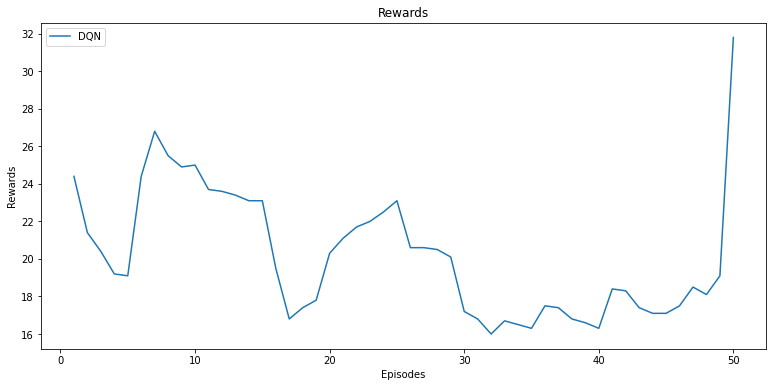

In [48]:
rewser = []
window = 10

env = gym.make("CartPole-v1")
neural_network = create_model(4, 2, 32, 2)
neural_network, score = DQN(env, neural_network, trials=100, goal_score=130, batch_size=32)

score = rolling(np.array(score), window)
rewser.append({"x": np.arange(1, len(score) + 1), "y": score, "ls": "-", "label": "DQN"})
plot(rewser, "Rewards", "Episodes", "Rewards")

**Standard DQN on CartPole results:**
<img src="images/results-dqn.png" width="600">